In [1]:
import fastbox as fb
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import curve_fit

In [2]:
import psutil
import os

print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3) )
print(u'当前使用的总内存占比：',info.percent)
print(u'cpu个数：',psutil.cpu_count())

当前进程的内存使用：0.2386 GB
电脑总内存：63.9449 GB
当前使用的总内存占比： 20.5
cpu个数： 8


$s: t$ 时刻的现货价格   
$T$ : 期权合约的总时间，当前时   
刻到交割期的时间为 $T-t$   
$k: t$ 时刻的交割价格   
$r:$ 无风险利率   
$\sigma:$ 现货价格的波动率

In [6]:
# 期权价格定价函数
def vanilla_option(S, K, T, r, sigma, option='C'):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T)/(sigma * np.sqrt(T))

    if option == 'C':
        p = (S*norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*norm.cdf(d2, 0.0, 1.0))
    elif option == 'P':
        p = (K*np.exp(-r*T)*norm.cdf(-d2, 0.0, 1.0) - S*norm.cdf(-d1, 0.0, 1.0))
    else:
        return None
    return p

In [7]:
def find_sigma(S, K, T, r, option, target_p,initial_guess = 0.5):
    """
    使用牛顿法寻找使得 vanilla_option 返回值与目标值 target_p 最接近的 sigma
    """
    def func(sigma):
        return vanilla_option(S, K, T, r, sigma, option) - target_p
    sigma_solution = newton(func, initial_guess)
    return sigma_solution

In [8]:
# 数据读取以及参数设置
spot_price=fb.data.futures.daily(instrumentid = 'CU2110',from_date = '2021-01-01',to_date = '2021-12-31')
option_price = fb.data.futuresoptions.daily(instrumentid = 'CU2110',from_date = '2021-04-16',to_date = '2021-04-16')

In [9]:
S=spot_price.loc['2021-04-16','close']
T=6
r=0.00

In [10]:
option_price.iloc[0,:]['close']

25722.0

想要画出volitility smile，需要反解出隐含波动率    
显式方法（我应该写不出来）……    
隐式方法（可能会比较慢）

In [11]:
strike_price=[]
sigma_BS=[]
for index in option_price.index:
    try:
        option=index[2]
        K=index[3]#交割价格
        target_p=option_price.loc[index,'close']
        sigma=find_sigma(S, K, T, r, option, target_p,initial_guess = 0.05)
        strike_price.append(K)
        sigma_BS.append(sigma)
    except:
        pass

In [12]:
y=lambda x, a, b, c: a*x**2+b*x+c #定义拟合函数
popt, pcov=curve_fit(y, strike_price, sigma_BS) #用curve_fit函数拟合
print("拟合的参数值为：", popt)

拟合的参数值为： [ 4.63896259e-11 -6.05794901e-06  2.57162757e-01]


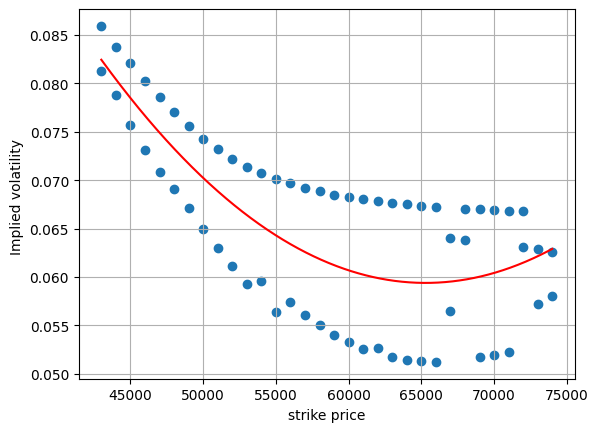

In [13]:
# 绘制图像
# 生成连续的数据点
x_dense = np.linspace(min(strike_price), max(strike_price), 1000)
# 计算拟合曲线上的点
y_dense = y(x_dense, *popt)
plt.clf()
plt.scatter(strike_price, sigma_BS)
plt.plot(x_dense, y_dense, color='red')  # 绘制拟合曲线
plt.xlabel('strike price')
plt.ylabel('Implied volatility ')
plt.grid(True)  # 添加网格线
plt.show()

In [ ]:
from scipy.stats import norm
from scipy.optimize import newton
N = norm.cdf()

def BS(forward, strike, mat, r, sigma, flag):
    """
    This function returns the BS price for an option on futures Flag = P or C
    We assume that sigma is yearly and r is yearly. mat is the number of days to maturity so tau = mat / 360
    """
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

# now for the implied volatility
# remember the put call parity
# BS(call) + BS(put) = discount * (forward - K)
# so if the strike is very high (for the put out of the money) then BS(put) is close to 0. then the corresponding call is equal to BS(call) = disount * (forward - K) - BS(put) and you search the implied vol for this call and strike
# the decision for in/out of the money is if K>forward then call if K<forward then put

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "C" and strike<K:
        flag = "P"
        price = discount * (forward - K) - price
    elif flag == "P" and strike >= K:
        flag = "C"
        price = discount * (forward - K) - price
    
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag)
    sigma = newton(root_func, 0.1)
    return sigma